In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# cd to your notebook location
%cd /content/gdrive/MyDrive/Notebooks/
%ls

/content/gdrive/.shortcut-targets-by-id/1X9Sxc_Ne4CT-A3FD4FmDIJyDyZN7a2mP/Notebooks
'Copy of RRL_autograd_Lily_copy.ipynb'   results/                       RRL_autograd_master.ipynb
 data/                                   results_by1123/                RRL_autograd_vishal.ipynb
 feature-engineering.ipynb               RRL_autograd_deep.ipynb        RRL_autograd_xinyi.ipynb
'Final Report.gdoc'                      RRL_autograd_irvin.ipynb       RRL_from_scratch.ipynb
 libta.deb                               RRL_autograd_Lily_copy.ipynb   ta.deb
 model/                                  RRL_autograd_Lily.ipynb        working_notes.gdoc


In [ ]:
#for Pytorch
!pip uninstall torch -qy
!pip install torch==1.13.0+cpu -f https://download.pytorch.org/whl/torch_stable.html -q

#For TA-Lib first time
#!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
#!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
#Please comment out line 5,6 for the following runtime
!dpkg -i libta.deb
!dpkg -i ta.deb
!pip install ta-lib -q

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import talib
from sklearn.preprocessing import StandardScaler
import pywt
import scipy
import sklearn
from sklearn.decomposition import PCA
from torch.nn.modules.container import ModuleList
from tqdm.notebook import tqdm,trange
import json
my_bar="{l_bar}{bar}|{n_fmt}/{total_fmt} [Elapsed: {elapsed}, Remaining: {remaining}, Speed: {rate_inv_fmt}]"

In [ ]:
print(torch.__version__)

1.13.0+cpu


### Preprocessing

In [ ]:
def create_TI(df):
    df_ti = pd.DataFrame()

    # Notes for the indicators: https://docs.google.com/document/d/1YCS1o-z_5Q-uq3_UDVLstW-R1Gi6xUXumaJxqzyELpY/edit --Lily

    #Momentum indicators
    #real = MOM(close, timeperiod=10)
    #macd, macdsignal, macdhist = MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    #real = MFI(high, low, close, volume, timeperiod=14)
    #real = RSI(close, timeperiod=14)

    df_ti['mom'] = pd.DataFrame(talib.MOM(df['Close'])) # Momentum (MOM)
    df_ti['macd'], df_ti['macdsignal'], df_ti['macdhist'] = talib.MACD(df['Close'])# Moving Average Convergence Divergence (MACD)
    df_ti['mfi'] = talib.MFI(df['High'],df['Low'],df['Close'],df['Volume'])# Money Flow Index (MFI)
    df_ti['rsi'] = talib.RSI(df['Close'])# Relative Strength Index (RSI)

    #Volatility Indicators
    #real = ATR(high, low, close, timeperiod=14)
    #real = NATR(high, low, close, timeperiod=14)

    df_ti['atr'] = talib.ATR(df['High'], df['Low'], df['Close'])# Average True Range (ATR)
    df_ti['natr'] = talib.NATR(df['High'], df['Low'], df['Close'])# Normalized Average True Range (NATR)

    #Cycle Indicators
    #real = HT_DCPHASE(close)
    #sine, leadsine = HT_SINE(close)
    #integer = HT_TRENDMODE(close)

    df_ti['htdcp'] = talib.HT_DCPHASE(df['Close'])# Hilbert Transform Dominant Cycle Phase (HTDCP)
    df_ti['hts'], df_ti['hts_lead'] = talib.HT_SINE(df['Close']) # Hilbert Transform Sinewave (HTS)
    df_ti['httmm'] = talib.HT_TRENDMODE(df['Close']) # Hilbert Transform Trend Market Mode (HTTMM)

    #Volume Indicators
    #real = ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    #real = OBV(close, volume)

    df_ti['co'] = talib.ADOSC(df['High'], df['Low'], df['Close'], df['Volume'])# Chaikin Oscillator (CO)
    df_ti['obv'] = talib.OBV(df['Close'], df['Volume'])# On Balance Volume (OBV)

    #df_ti['returns'] = (df['Close']-df['Open'])/df['Open']
    df_ti['returns'] = (df['Close']-df['Open'])
    df_ti['Close'] = df['Close']

    df_ti.dropna(inplace=True)
    df_ti.reset_index(drop=True,inplace=True)

    returns = df_ti['returns']
    df_ti.drop('returns', axis = 1, inplace = True)

    close = df_ti['Close']
    df_ti.drop('Close', axis = 1, inplace = True)

    return df_ti, returns, close

def normalize(data):
    data=(data-data.mean())/data.std()
    return data

def apply_PCA(data,ratio=0.95):
    pca = PCA(n_components=ratio)
    pca.fit(data)
    data_pca=pca.transform(data)
    data_pca=pd.DataFrame(data_pca,columns=["PCA_"+str(i) for i in range(data_pca.shape[1])])
    return data_pca


def apply_DWT(signal,level=4,threshold=2):
    #DWT with level=4
    coeffs= pywt.wavedec(signal, wavelet='haar',mode="periodization", level=level)
    #soft thresholding applied to all detail coefficients
    for i in range(1,level+1): #12/14
        coeffs[i]=pywt.threshold(coeffs[i],threshold*np.std(coeffs[i]),'soft',0)
    #inverse DWT
    reconstructed_signal=pywt.waverec(coeffs,'haar')
    return reconstructed_signal

def preprocessing_pipeline(df_ti, mType, level=4,threshold=2):
    df_ti_norm=normalize(df_ti)
    df_pca=apply_PCA(df_ti_norm)
    df_dwt=df_ti_norm.apply(apply_DWT,args=[level,threshold])
    df_pca_dwt=df_pca.apply(apply_DWT,args=[level,threshold])

    if mType == 'ti' or mType == 'TI':
        return df_ti_norm
    elif mType == 'pca' or mType == 'PCA':
        return df_pca
    elif mType == 'dwt' or mType == 'DWT':
        return df_dwt
    elif mType =='pca&dwt' or mType == 'PCA&DWT':
        return df_pca_dwt

### Define the Model Structure

#### Our version-11.11

In [ ]:
class RRLModel(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
        self.neuron = nn.Linear(m+1, 1, bias = True)
        #nn.init.uniform_(self.neuron.weight, -.2, .2)
        nn.init.xavier_uniform_(self.neuron.weight)
        #nn.init.xavier_normal_(self.neuron.weight)
        nn.init.constant_(self.neuron.bias, 0)

    def forward(self, features):
        return torch.tanh(self.neuron(features))#use tanh or sign? We need Ft={-1,1}


class RRLTrainer:
    def __init__(self, model: RRLModel, lr: float, delta: float, T: int, lamb: float, early_stop: bool):
        self.model = model
        self.lr = lr
        self.delta = delta
        self.T = T
        self.lamb=lamb
        self.early_stop=early_stop
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lamb)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    def sharpe_ratio(self,returns: torch.Tensor, bias: int = 1e-6):
        mean = torch.mean(returns, dim=-1)
        std = torch.std(returns, dim=-1,correction=0) + bias
        return mean/std

    def reward_function(self, rt: torch.Tensor, Ft: torch.Tensor):
        returns = Ft[:-1] * rt - self.delta * (torch.abs(Ft[1:] - Ft[:-1]))
        sharpe = self.sharpe_ratio(returns)
        return returns, sharpe

    def predict_Ft(self, X: torch.Tensor, prev: torch.Tensor):
        Ft1_values = torch.zeros(X.shape[0]+1).to(self.device)
        Ft1_values[0]=prev
        for i in range(len(X)-1):
            x_i=torch.cat([X[i],Ft1_values[i].detach().unsqueeze(0)],0).float()
            Ft1_values[i+1] = self.model(x_i)

        Ft1_adjusted = Ft1_values.clone()
        Ft1_adjusted[Ft1_adjusted == 0] = -1
        return torch.sign(Ft1_adjusted)


    def gradient_ascent(self, X: torch.Tensor, rt: torch.Tensor):
        batches = int(X.shape[0] / self.T)
        self.last_reward= None
        consecutive_no_gain = 0

        for epoch in trange(self.epochs,unit="iteration",bar_format=f"{my_bar}"):

            prevFt= torch.tensor([1]).float()# Going Long on Day 0, initializing prevFt to 1
            for batch in range(batches):
                index = batch * self.T
                self.optimizer.zero_grad()
                Ft1 = self.predict_Ft(X[index :index + self.T], prevFt)
                returns, reward = self.reward_function(rt[index :index + self.T], Ft1.clone())
                reward = reward.clone()
                (-1 * reward).backward(retain_graph=True)
                self.optimizer.step()
                prevFt = Ft1[-1].clone().unsqueeze(0)

            if self.early_stop==True:
                rewards_,_,_ = self.test(X, rt)
                if self.last_reward is not None:
                    reward_difference = rewards_  - self.last_reward
                    if reward_difference <= 0:
                        consecutive_no_gain += 1
                        if consecutive_no_gain >= 2:  # Check if it's the second consecutive epoch
                            print(f"Early stopping activated at epoch {epoch+1}.")
                            return
                    else:
                        consecutive_no_gain = 0  # Reset counter if there is a gain

                self.last_reward = rewards_

    def train(self, X: torch.Tensor, rt: torch.Tensor, epochs: int = 100):
        self.epochs = epochs
        self.gradient_ascent(X, rt)

    def test(self, X_test: torch.Tensor, rt_test: torch.Tensor):
        prevFt= torch.tensor([1]).float()
        test_Ft=self.predict_Ft(X_test, prevFt)
        test_returns, test_rewards = self.reward_function(rt_test, test_Ft)
        return test_rewards, test_returns, test_Ft[1:] #test_Ft contains prev_Ft,excluding that

## Train the model



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T=5
epochs=100
lamb=0.05  #l2 regularization parameter
N_train = 500
N_test = 500

In [ ]:
# delta
# NYSE: 1
# XOM: 0.01
# ZCF: 0.001

In [ ]:
import math
# Metrics Used to Measure the Performance of Different Methods
def cumulative_returns(returns):
  return np.cumsum(returns)

def NP(returns):
  return np.sum(returns)

def ASR(returns):
  return np.sqrt(252)*(np.mean(returns)-0.01)/(np.std(returns))

#MP_0=df_close[500]
def APY(returns,P_T,MP_0):
  val=(P_T+MP_0)/MP_0
  sign=np.sign(val) # for situations when val is less than zero, Can't find root of a negative number
  apy= sign *math.pow(np.abs(val) , (252.0/len(returns)) )-1
  return apy

def MDD(returns):
  time_series=np.cumsum(returns)
  drawdown=( np.maximum.accumulate(time_series) - time_series ) / np.maximum.accumulate(time_series)
  return np.max(drawdown)

def CR(apy,mdd):
    if mdd == 0:
        return np.inf
    return apy/mdd

def get_metrics(returns,MP_0):
  Metrics=["NP($)","APY","ASR","MD","CR"]
  np=NP(returns)
  apy=APY(returns,np,MP_0)
  asr=ASR(returns)
  mdd=MDD(returns)
  cr=CR(apy,mdd)
  df=pd.DataFrame({"Metrics":Metrics,"Values":[np,apy,asr,mdd,cr]})

  return df

def add_columns(df,df_name,model_name):
  df.insert(0,"Model",model_name)
  df.insert(0,"Dataset",df_name)
  return df

In [ ]:
def read_file(path):
  df = pd.read_csv(path)
  df.drop(columns = ['Name'], inplace = True)
  df['Date'] = pd.to_datetime(df['Date'])
  return df
# change to your path
results_path="/content/gdrive/MyDrive/Notebooks/results/"

def save_results(test_returns,test_rewards,test_ft,df_name,model_name, T, eS):
  data={"test_returns":test_returns,"test_rewards":test_rewards,"test_ft":test_ft}
  json_object = json.dumps(data, indent=4)
  with open(f'{results_path}/{df_name}_{model_name}_T{T}_earlyStop{eS}.json', "w+") as outfile:
    outfile.write(json_object)

def read_results(df_name,model_name, T, eS):
  with open(f'{results_path}/{df_name}_{model_name}_T{T}_earlyStop{eS}.json', 'r') as openfile:
    json_object = json.load(openfile)
  return json_object


def rolling_training_testing(df,returns,df_name:str,model_name:str,delta,N_train=500,N_test=500,T=5,lr=0.1,epochs=100,lamb=0.01,early_stop=True):

  X = torch.tensor(df.values) #, requires_grad = True)
  rt = torch.tensor(returns.values)
  seed=42
  torch.manual_seed(seed)
  model = RRLModel(X.shape[-1]).float().to(device)
  torch.autograd.set_detect_anomaly(True)
  trainer = RRLTrainer(model, lr, delta, T, lamb, early_stop)

  rewards_list=[]
  returns_list=[]
  ft_list=[]

  for i in range(10):
    start=i*N_train
    print(f"Training on Batch {i+1}")
    X_train = X[start:start+N_train].float().to(device)
    rt_train = rt[start:start+N_train].float().to(device)
    trainer.train(X_train, rt_train, epochs)

    print(f"Testing on Batch {i+2}")
    X_test = X[start+N_train:start+N_train+N_test].float().to(device)
    rt_test = rt[start+N_train:start+N_train+N_test].float().to(device)
    test_rewards,test_returns,test_ft=trainer.test(X_test,rt_test)

    rewards_list.append(test_rewards.detach().cpu().numpy().tolist())
    returns_list.extend(test_returns.detach().cpu().numpy().tolist())
    ft_list.extend(test_ft.detach().cpu().numpy().tolist())
    print()

  path = '/content/gdrive/MyDrive/Notebooks/model/{}_{}_{}_{}_RRL.pth'.format(df_name,model_name,T,early_stop)
  torch.save(model.state_dict(), path)
  print('Successfully saved {} RRL model for {}'.format(model_name,df_name))

  return rewards_list,returns_list,ft_list

In [ ]:
epochs=100
lamb=0.01
torch.manual_seed(42)
seed=42
df_names=["Exxon","Corn"]
# please chanfe into you model name
model_names='pca&dwt'
deltas=[0.01,0.001]
T = [5]
early_stop = [True]
metrics_df=pd.DataFrame(columns=["Dataset","Model","Metrics","Values"])


for i,df_name in enumerate(df_names):
  for y in T:
    for m in early_stop:
      df = read_file(f"data/{df_name}_20yr_OHLC.csv")
      df_ti, returns, df_close = create_TI(df)
      df_transformed = preprocessing_pipeline(df_ti,model_names)

      test_rewards,test_returns,test_ft=rolling_training_testing(df_transformed,returns,df_name,model_names,delta=deltas[0],epochs=epochs,lamb=lamb,T=y,early_stop=m)
      save_results(test_returns,test_rewards,test_ft,df_name,model_names,y,m)
      # metrics = get_metrics(test_returns,df_close[500]).style.set_caption(f"NYSE-PCA&DWT-Seed={seed},T={y},Epochs={epochs}").data
      # print(metrics)
      # metrics=add_columns(metrics, df_name, model_names)
      # metrics_df=pd.concat([metrics_df,metrics])

Training on Batch 1


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 13.
Testing on Batch 2

Training on Batch 2


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 7.
Testing on Batch 3

Training on Batch 3


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 10.
Testing on Batch 4

Training on Batch 4


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 5.
Testing on Batch 5

Training on Batch 5


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 3.
Testing on Batch 6

Training on Batch 6


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 3.
Testing on Batch 7

Training on Batch 7


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 7.
Testing on Batch 8

Training on Batch 8


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 7.
Testing on Batch 9

Training on Batch 9


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 7.
Testing on Batch 10

Training on Batch 10


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 8.
Testing on Batch 11

Successfully saved pca&dwt RRL model for Exxon
Training on Batch 1


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 4.
Testing on Batch 2

Training on Batch 2


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 12.
Testing on Batch 3

Training on Batch 3


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 3.
Testing on Batch 4

Training on Batch 4


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 11.
Testing on Batch 5

Training on Batch 5


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 5.
Testing on Batch 6

Training on Batch 6


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 6.
Testing on Batch 7

Training on Batch 7


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 7.
Testing on Batch 8

Training on Batch 8


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 10.
Testing on Batch 9

Training on Batch 9


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 14.
Testing on Batch 10

Training on Batch 10


  0%|          |0/100 [Elapsed: 00:00, Remaining: ?, Speed: ?s/iteration]

Early stopping activated at epoch 9.
Testing on Batch 11

Successfully saved pca&dwt RRL model for Corn


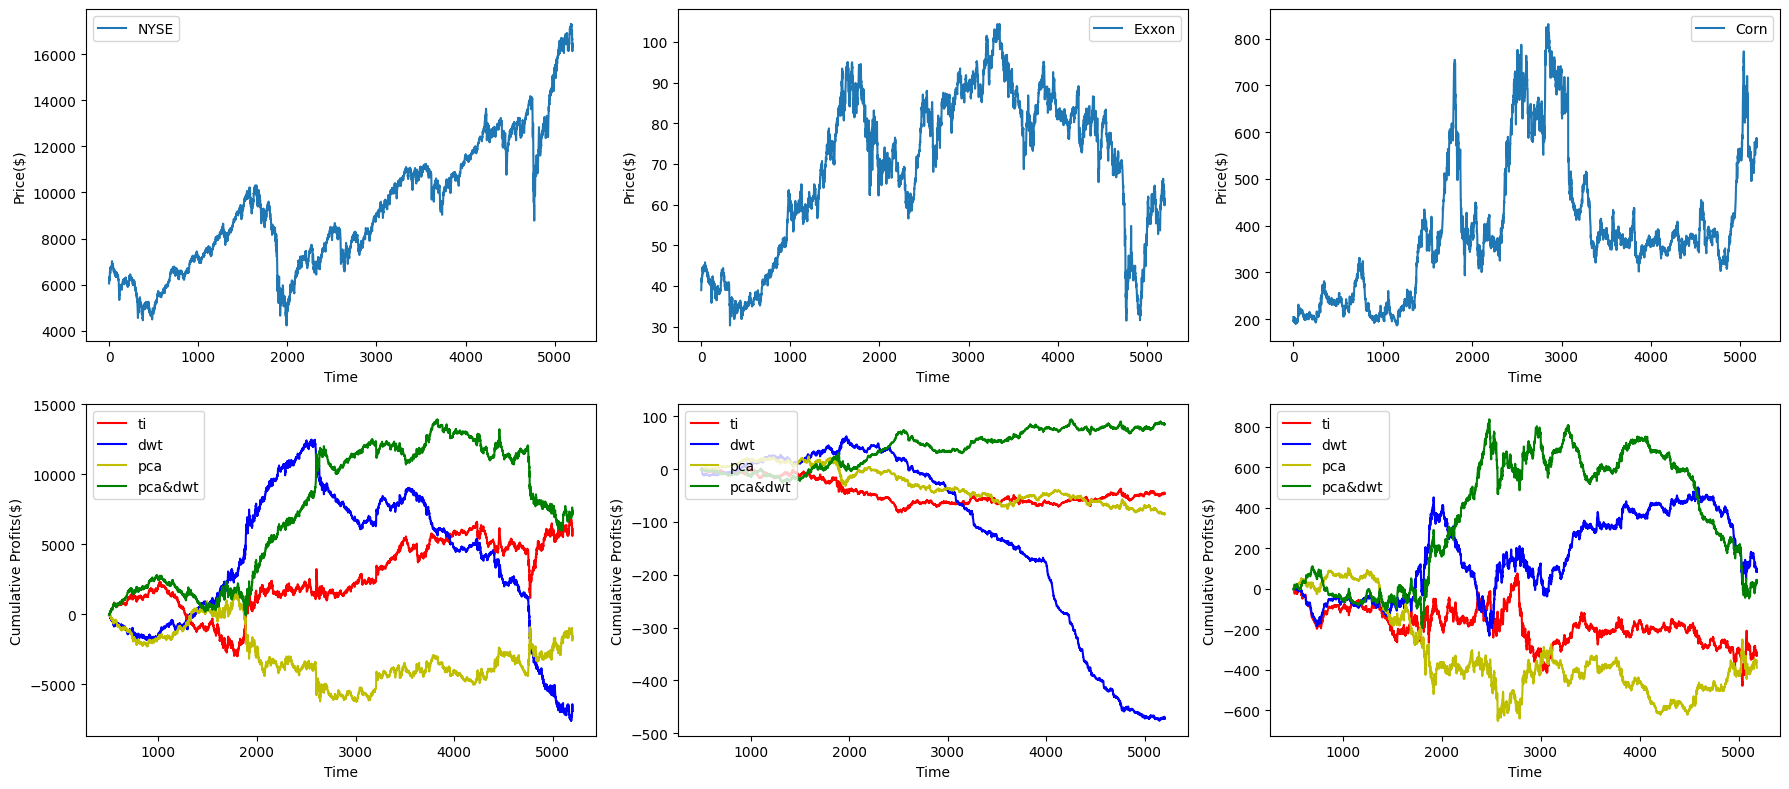

In [ ]:
from matplotlib import pyplot as plt
epochs = 100
lamb = 0.01
df_names = ["NYSE", "Exxon", "Corn"]
model_names = ['ti', 'dwt', 'pca', 'pca&dwt']
seed = 42
torch.manual_seed(seed)
deltas = [1, 0.01, 0.001]
T = 5
early_stop = True
cr = ['r', 'b', 'y', 'g']

# Create a figure object with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 8))  # 2 rows, 3 columns

for i, df_name in enumerate(df_names):
    NP = []
    df = read_file(f"data/{df_name}_20yr_OHLC.csv")
    df_ti, returns, df_close = create_TI(df)

    # Plot the price series in the first column
    axs[0, i].plot(df_close.index.values, df_close.values, label=df_name)
    axs[0, i].set_xlabel('Time')
    axs[0, i].set_ylabel('Price($)')
    axs[0, i].legend()

    for model_name in model_names:
        df_transformed = preprocessing_pipeline(df_ti, model_name)
        results = read_results(df_name, model_name, T, early_stop)
        test_rewards, test_returns, test_ft = results['test_rewards'], results['test_returns'], results['test_ft']
        NP.append(np.cumsum(test_returns))

    # Plot the cumulative profits in the second column
    for j, model_name in enumerate(model_names):
        axs[1, i].plot(df_close.index.values[500:], NP[j], label=model_name, color=cr[j])
    axs[1, i].set_xlabel('Time')
    axs[1, i].set_ylabel('Cumulative Profits($)')
    axs[1, i].legend(loc='upper left')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

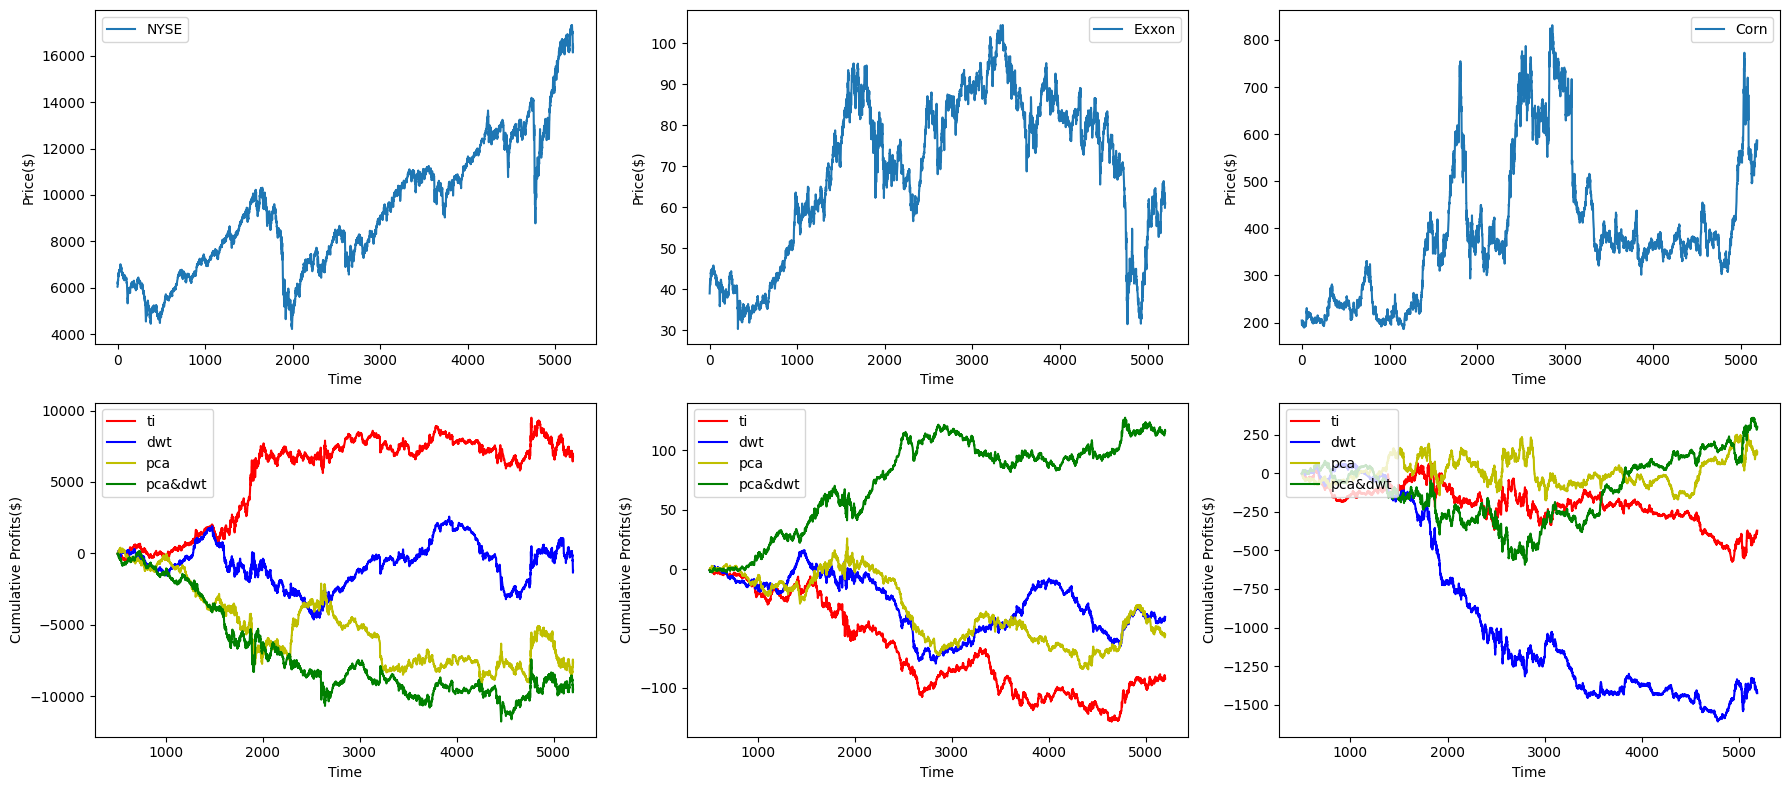

In [ ]:
from matplotlib import pyplot as plt
epochs = 100
lamb = 0.01
df_names = ["NYSE", "Exxon", "Corn"]
model_names = ['ti', 'dwt', 'pca', 'pca&dwt']
seed = 42
torch.manual_seed(seed)
deltas = [1, 0.01, 0.001]
T = 5
early_stop = False
cr = ['r', 'b', 'y', 'g']

# Create a figure object with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 8))  # 2 rows, 3 columns

for i, df_name in enumerate(df_names):
    NP = []
    df = read_file(f"data/{df_name}_20yr_OHLC.csv")
    df_ti, returns, df_close = create_TI(df)

    # Plot the price series in the first column
    axs[0, i].plot(df_close.index.values, df_close.values, label=df_name)
    axs[0, i].set_xlabel('Time')
    axs[0, i].set_ylabel('Price($)')
    axs[0, i].legend()

    for model_name in model_names:
        df_transformed = preprocessing_pipeline(df_ti, model_name)
        results = read_results(df_name, model_name, T, early_stop)
        test_rewards, test_returns, test_ft = results['test_rewards'], results['test_returns'], results['test_ft']
        NP.append(np.cumsum(test_returns))

    # Plot the cumulative profits in the second column
    for j, model_name in enumerate(model_names):
        axs[1, i].plot(df_close.index.values[500:], NP[j], label=model_name, color=cr[j])
    axs[1, i].set_xlabel('Time')
    axs[1, i].set_ylabel('Cumulative Profits($)')
    axs[1, i].legend(loc='upper left')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
metrics_df

In [ ]:
from matplotlib import pyplot as plt
epochs=100
lamb=0.01
torch.manual_seed(42)

df_names=["NYSE","Exxon","Corn"]
# please chanfe into you model name
model_names='dwt'
seed=42
torch.manual_seed(seed)
deltas=[1,0.01,0.001]
T = [5]
early_stop = [False, True]

for i,df_name in enumerate(df_names):
  for y in T:
    for m in early_stop:
      df = read_file(f"data/{df_name}_20yr_OHLC.csv")
      df_ti, returns, df_close = create_TI(df)
      df_transformed = preprocessing_pipeline(df_ti,model_names)
      test_rewards,test_returns,test_ft = read_results(df_name,model_names, y, m)

Test_returns_PCADWT_NYSE = np.loadtxt("results/Test_returns_PCA&DWT_NYSE.txt")
Test_returns_DWT_NYSE = np.loadtxt("results/Test_returns_DWT_NYSE.txt")
Test_returns_PCA_NYSE = np.loadtxt("results/Test_returns_PCA_NYSE.txt")
Test_returns_TI_NYSE = np.loadtxt("results/Test_returns_TI_NYSE.txt")

dates1 = df['Date'].values[-4702:]

fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot the price series on the primary axis
plt.plot(dates1, np.cumsum(Test_returns_PCADWT_NYSE), label='PCA&DWT', c='r')
plt.plot(dates1, np.cumsum(Test_returns_TI_NYSE), label='TI', c='b')
plt.plot(dates1, np.cumsum(Test_returns_DWT_NYSE), label='DWT', c='y')
plt.plot(dates1, np.cumsum(Test_returns_PCA_NYSE), label='PCA', c='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Profits($)')
ax1.tick_params(axis='y')
# Set the grid and legend
ax1.grid(axis='y', alpha=0.7,linewidth='1')
ax1.legend(loc='upper left')

# Use a secondary y-axis for the returns bar chart
ax2 = ax1.twinx()
ax2.bar(dates1, np.abs(Test_returns_PCADWT_NYSE), color=np.where(Test_returns_PCADWT_NYSE < 0, 'red', 'green'), alpha=0.2, width=2.0)
ax2.set_ylabel('Daily Profit($)')
ax2.tick_params(axis='y')
ax2.grid(axis='y',alpha=0.2,linewidth='0.5')

plt.title('Cumulative Profits with Daily Profits')
plt.show()

In [ ]:
metrics_df

## Test the model (Do not run)

In [ ]:
%ls results

 Corn_DWT.json                           Test_returns_DWT_NYSE.txt
 Corn_dwt_T5_earlyStopFalse.json         Test_returns_DWT_XOM.txt
 Corn_dwt_T5_earlyStopTrue.json          Test_returns_DWT_ZCF.txt
'Corn_PCA&DWT.json'                      Test_returns_pca_Corn.txt
'Corn_pca&dwt_T5_earlyStopFalse.json'    Test_returns_pcadwt_Corn.txt
'Corn_pca&dwt_T5_earlyStopTrue.json'     Test_returns_pcadwt_Exxon.txt
 Corn_pca_T5_earlyStopFalse.json         Test_returns_pcadwt_NYSE.txt
 Corn_pca_T5_earlyStopTrue.json         'Test_returns_PCA&DWT_NYSE.txt'
 Corn_ti_T5_earlyStopFalse.json         'Test_returns_PCA&DWT_XOM.txt'
 Corn_ti_T5_earlyStopTrue.json          'Test_returns_PCA&DWT_ZCF.txt'
 Exxon_DWT.json                          Test_returns_pca_Exxon.txt
 Exxon_dwt_T5_earlyStopFalse.json        Test_returns_pca_NYSE.txt
 Exxon_dwt_T5_earlyStopTrue.json         Test_returns_PCA_NYSE.txt
'Exxon_PCA&DWT.json'                     Test_returns_PCA_XOM.txt
'Exxon_pca&dwt_T5_earlyStopFalse.json'   

In [ ]:
Test_rewards_NYSE = np.loadtxt("results/Test_rewards_pcadwt_NYSE.txt")
Test_returns_NYSE = np.loadtxt("results/Test_returns_pcadwt_NYSE.txt")
Test_Ft_NYSE = np.loadtxt("results/Test_ft_pcadwt_NYSE.txt")
Test_rewards_Exxon = np.loadtxt("results/Test_rewards_pcadwt_Exxon.txt")
Test_returns_Exxon = np.loadtxt("results/Test_returns_pcadwt_Exxon.txt")
Test_Ft_Exxon = np.loadtxt("results/Test_ft_pcadwt_Exxon.txt")
Test_rewards_Corn = np.loadtxt("results/Test_rewards_pcadwt_Corn.txt")
Test_returns_Corn = np.loadtxt("results/Test_returns_pcadwt_Corn.txt")
Test_Ft_Corn = np.loadtxt("results/Test_ft_pcadwt_Corn.txt")

In [ ]:
print(f"Test Rewards for pcadwt RRL on NYSE: {sum(Test_rewards_NYSE)/len(Test_rewards_NYSE)}")
print(f"Test Rewards for pcadwt RRL on Exxon: {sum(Test_rewards_Exxon)/len(Test_rewards_Exxon)}")
print(f"Test Rewards for pcadwt RRL on Corn: {sum(Test_rewards_Corn)/len(Test_rewards_Corn)}")

Test Rewards for PCA&DWT RRL on NYSE: 0.02840208662673831
Test Rewards for PCA&DWT RRL on XOM: 0.007086329907178879
Test Rewards for PCA&DWT RRL on ZCF: 0.006778202205896378


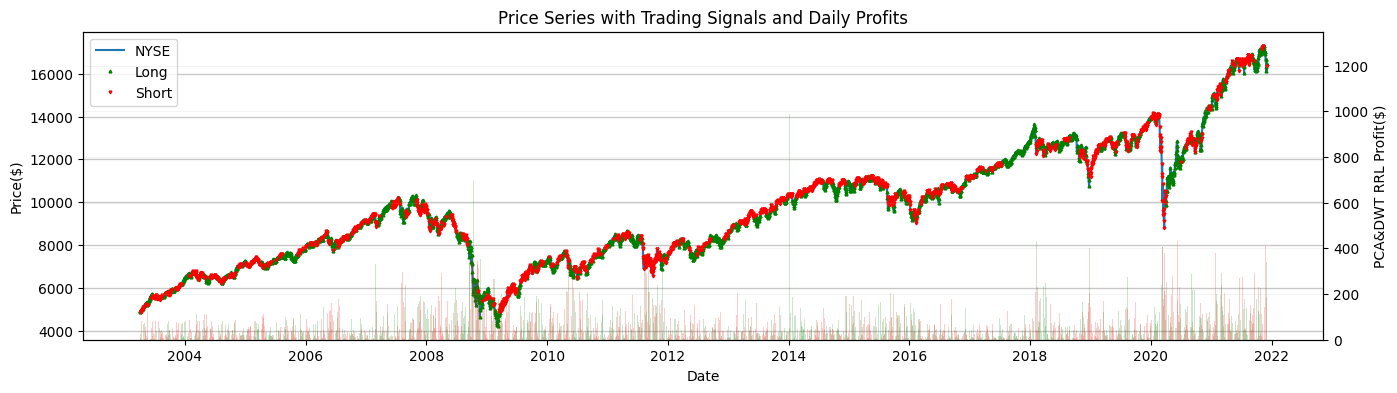

In [ ]:
price_series = create_TI(df)[2].values[-4702:]
dates = df['Date'].values[-4702:]
# Plot Test Ft
buy_positions = np.where(Test_Ft_NYSE == 1)[0]
sell_positions = np.where(Test_Ft_NYSE == -1)[0]
import matplotlib.pyplot as plt

# Create the figure and a twin axis for the bar chart
fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot the price series on the primary axis
plt.plot(dates, price_series, label='NYSE')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price($)')
ax1.tick_params(axis='y')

# Use a secondary y-axis for the returns bar chart
ax2 = ax1.twinx()
ax2.bar(dates, np.abs(Test_returns_NYSE), color=np.where(Test_returns_NYSE < 0, 'red', 'green'), alpha=0.2, width=2.0)
ax2.set_ylabel('PCA&DWT RRL Profit($)')
ax2.tick_params(axis='y')
ax2.grid(axis='y',alpha=0.2,linewidth='0.5')

# Plot the buy signals
ax1.plot(np.array(dates)[buy_positions], price_series[buy_positions], lw=0, color='green', label='Long', marker='^', markersize=2)

# Plot the sell signals
ax1.plot(np.array(dates)[sell_positions], price_series[sell_positions],lw=0, color='red', label='Short', marker='v', markersize=2)

# Set the grid and legend
ax1.grid(axis='y', alpha=0.7,linewidth='1')
ax1.legend(loc='upper left')

plt.title('Price Series with Trading Signals and Daily Profits')
# plt.show()
plt.savefig('results/Trading_NYSE')

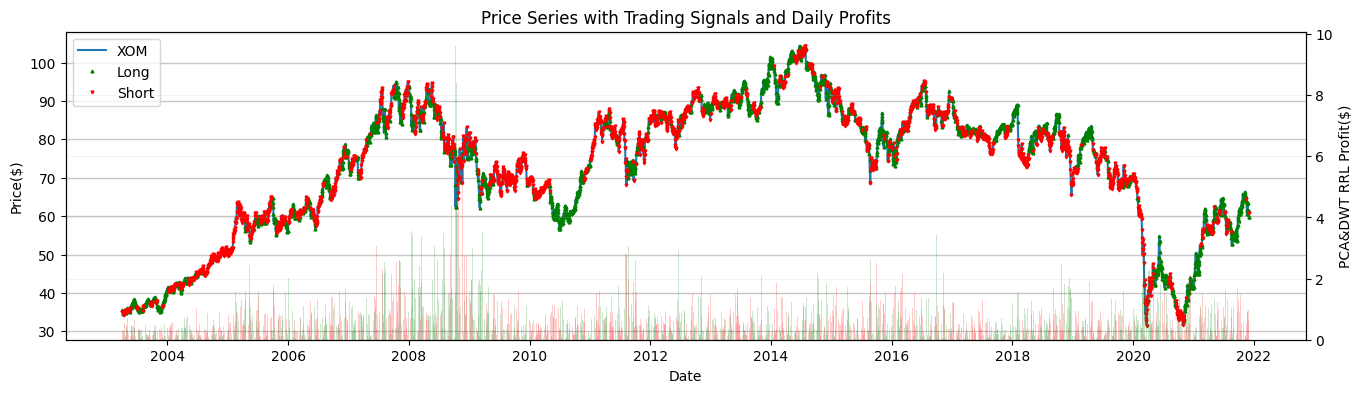

In [ ]:
price_series = create_TI(df2)[2].values[-4702:]
dates = df2['Date'].values[-4702:]
# Plot Test Ft
buy_positions = np.where(Test_Ft_XOM == 1)[0]
sell_positions = np.where(Test_Ft_XOM == -1)[0]
import matplotlib.pyplot as plt

# Create the figure and a twin axis for the bar chart
fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot the price series on the primary axis
plt.plot(dates, price_series, label='XOM')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price($)')
ax1.tick_params(axis='y')

# Use a secondary y-axis for the returns bar chart
ax2 = ax1.twinx()
ax2.bar(dates, np.abs(Test_returns_XOM), color=np.where(Test_returns_XOM < 0, 'red', 'green'), alpha=0.2, width=2.0)
ax2.set_ylabel('PCA&DWT RRL Profit($)')
ax2.tick_params(axis='y')
ax2.grid(axis='y',alpha=0.2,linewidth='0.5')

# Plot the buy signals
ax1.plot(np.array(dates)[buy_positions], price_series[buy_positions], lw=0, color='green', label='Long', marker='^', markersize=2)

# Plot the sell signals
ax1.plot(np.array(dates)[sell_positions], price_series[sell_positions],lw=0, color='red', label='Short', marker='v', markersize=2)

# Set the grid and legend
ax1.grid(axis='y', alpha=0.7,linewidth='1')
ax1.legend(loc='upper left')

plt.title('Price Series with Trading Signals and Daily Profits')
# plt.show()
plt.savefig('results/Trading_XOM')

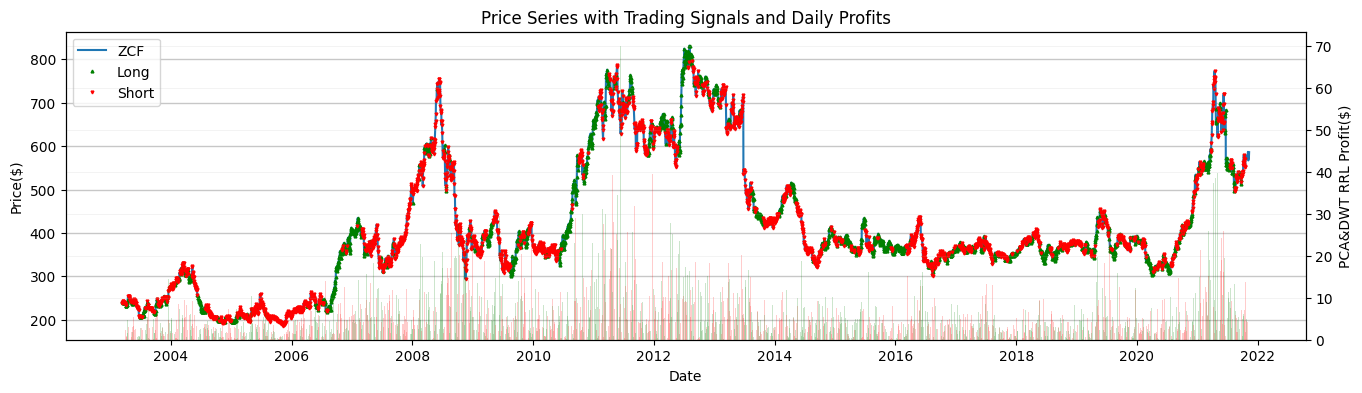

In [ ]:
price_series = create_TI(df3)[2].values[-4702:]
dates = df3['Date'].values[-4702:]
# Plot Test Ft
buy_positions = np.where(Test_Ft_ZCF == 1)[0]
sell_positions = np.where(Test_Ft_ZCF == -1)[0]
import matplotlib.pyplot as plt

# Create the figure and a twin axis for the bar chart
fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot the price series on the primary axis
plt.plot(dates, price_series, label='ZCF')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price($)')
ax1.tick_params(axis='y')

# Use a secondary y-axis for the returns bar chart
ax2 = ax1.twinx()
ax2.bar(dates[16:], np.abs(Test_returns_ZCF), color=np.where(Test_returns_ZCF < 0, 'red', 'green'), alpha=0.2, width=2.0)
ax2.set_ylabel('PCA&DWT RRL Profit($)')
ax2.tick_params(axis='y')
ax2.grid(axis='y',alpha=0.2,linewidth='0.5')

# Plot the buy signals
ax1.plot(np.array(dates)[buy_positions], price_series[buy_positions], lw=0, color='green', label='Long', marker='^', markersize=2)

# Plot the sell signals
ax1.plot(np.array(dates)[sell_positions], price_series[sell_positions],lw=0, color='red', label='Short', marker='v', markersize=2)

# Set the grid and legend
ax1.grid(axis='y', alpha=0.7,linewidth='1')
ax1.legend(loc='upper left')

plt.title('Price Series with Trading Signals and Daily Profits')
# plt.show()
plt.savefig('results/Trading_ZCF')

In [ ]:
%ls results/

'Corn_PCA&DWT.json'          Test_returns_pca_Corn.txt       'Test_rewards_PCA&DWT_ZCF.txt'
'Exxon_PCA&DWT.json'         Test_returns_pcadwt_Corn.txt     Test_rewards_pca_Exxon.txt
'NYSE_PCA&DWT.json'          Test_returns_pcadwt_Exxon.txt    Test_rewards_pca_NYSE.txt
 Test_ft_DWT_NYSE.txt        Test_returns_pcadwt_NYSE.txt     Test_rewards_PCA_NYSE.txt
 Test_ft_DWT_XOM.txt        'Test_returns_PCA&DWT_NYSE.txt'   Test_rewards_PCA_XOM.txt
 Test_ft_DWT_ZCF.txt        'Test_returns_PCA&DWT_XOM.txt'    Test_rewards_PCA_ZCF.txt
 Test_ft_pca_Corn.txt       'Test_returns_PCA&DWT_ZCF.txt'    Test_rewards_TI_NYSE.txt
 Test_ft_pcadwt_Corn.txt     Test_returns_pca_Exxon.txt       Test_rewards_TI_XOM.txt
 Test_ft_pcadwt_Exxon.txt    Test_returns_pca_NYSE.txt        Test_rewards_TI_ZCF.txt
 Test_ft_pcadwt_NYSE.txt     Test_returns_PCA_NYSE.txt        Trading_DWT_NYSE.png
'Test_ft_PCA&DWT_NYSE.txt'   Test_returns_PCA_XOM.txt         Trading_DWT_XOM.png
'Test_ft_PCA&DWT_XOM.txt'    Test_returns_PCA

In [ ]:
Test_rewards_NYSE = np.loadtxt("results/Test_rewards_pcadwt_NYSE.txt")
Test_returns_NYSE = np.loadtxt("results/Test_returns_pcadwt_NYSE.txt")
Test_Ft_NYSE = np.loadtxt("results/Test_ft_pcadwt_NYSE.txt")
Test_rewards_Exxon = np.loadtxt("results/Test_rewards_pcadwt_Exxon.txt")
Test_returns_Exxon = np.loadtxt("results/Test_returns_pcadwt_Exxon.txt")
Test_Ft_Exxon = np.loadtxt("results/Test_ft_pcadwt_Exxon.txt")
Test_rewards_Corn = np.loadtxt("results/Test_rewards_pcadwt_Corn.txt")
Test_returns_Corn = np.loadtxt("results/Test_returns_pcadwt_Corn.txt")
Test_Ft_Corn = np.loadtxt("results/Test_ft_pcadwt_Corn.txt")

In [ ]:
df_names=["NYSE","Exxon","Corn"]
model_names='pcadwt'
deltas=[1,0.01,0.001]

metrics_df=pd.DataFrame(columns=["Dataset","Model","Metrics","Values"])

for i,df_name in enumerate(df_names):
    print('start on {}'.format(df_name))
    df = pd.read_csv(f"data/{df_name}_20yr_OHLC.csv")
    df.drop(columns = ['Name'], inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    # df = read_file(f"data/{df_name}_20yr_OHLC.csv")
    df_ti, returns, df_close = create_TI(df)
    Test_rewards_NYSE = np.loadtxt("results/Test_rewards_{}_{}.txt".format(model_names, df_name))
    Test_returns_NYSE = np.loadtxt("results/Test_returns_{}_{}.txt".format(model_names, df_name))
    Test_Ft_NYSE = np.loadtxt("results/Test_ft_{}_{}.txt".format(model_names, df_name))
    print("model rewards on {}: {}".format(df_name, Test_rewards_NYSE))
    metrics=get_metrics(Test_returns_NYSE,df_close[500])
    metrics=add_columns(metrics,df_name, model_names)
    metrics_df=pd.concat([metrics_df,metrics])

start on NYSE
model rewards on NYSE: [-0.03308796 -0.0680567   0.01362133 -0.06981382  0.00625529  0.02976019
 -0.05979305 -0.01401719 -0.00915688 -0.13445035]
start on Exxon
model rewards on Exxon: [ 0.09085801  0.07072563  0.02111426 -0.02741426 -0.04362283 -0.00847713
 -0.00827466  0.04193368  0.02142222 -0.05823392]
start on Corn
model rewards on Corn: [ 0.00297884 -0.00788893 -0.07679961 -0.04921024  0.01409967 -0.00526283
  0.03133042  0.06137736 -0.10617275  0.0539294 ]


## Measurement Matrix(do not run)

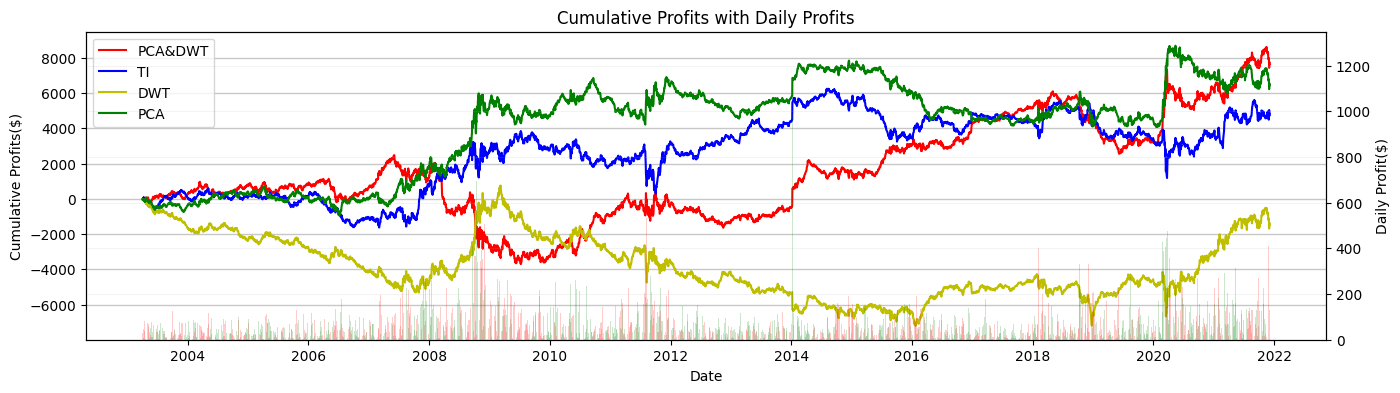

In [ ]:
from matplotlib import pyplot as plt
Test_returns_PCADWT_NYSE = np.loadtxt("results/Test_returns_PCA&DWT_NYSE.txt")
Test_returns_DWT_NYSE = np.loadtxt("results/Test_returns_DWT_NYSE.txt")
Test_returns_PCA_NYSE = np.loadtxt("results/Test_returns_PCA_NYSE.txt")
Test_returns_TI_NYSE = np.loadtxt("results/Test_returns_TI_NYSE.txt")

dates1 = df['Date'].values[-4702:]

fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot the price series on the primary axis
plt.plot(dates1, np.cumsum(Test_returns_PCADWT_NYSE), label='PCA&DWT', c='r')
plt.plot(dates1, np.cumsum(Test_returns_TI_NYSE), label='TI', c='b')
plt.plot(dates1, np.cumsum(Test_returns_DWT_NYSE), label='DWT', c='y')
plt.plot(dates1, np.cumsum(Test_returns_PCA_NYSE), label='PCA', c='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Profits($)')
ax1.tick_params(axis='y')
# Set the grid and legend
ax1.grid(axis='y', alpha=0.7,linewidth='1')
ax1.legend(loc='upper left')

# Use a secondary y-axis for the returns bar chart
ax2 = ax1.twinx()
ax2.bar(dates1, np.abs(Test_returns_PCADWT_NYSE), color=np.where(Test_returns_PCADWT_NYSE < 0, 'red', 'green'), alpha=0.2, width=2.0)
ax2.set_ylabel('Daily Profit($)')
ax2.tick_params(axis='y')
ax2.grid(axis='y',alpha=0.2,linewidth='0.5')

plt.title('Cumulative Profits with Daily Profits')
plt.show()

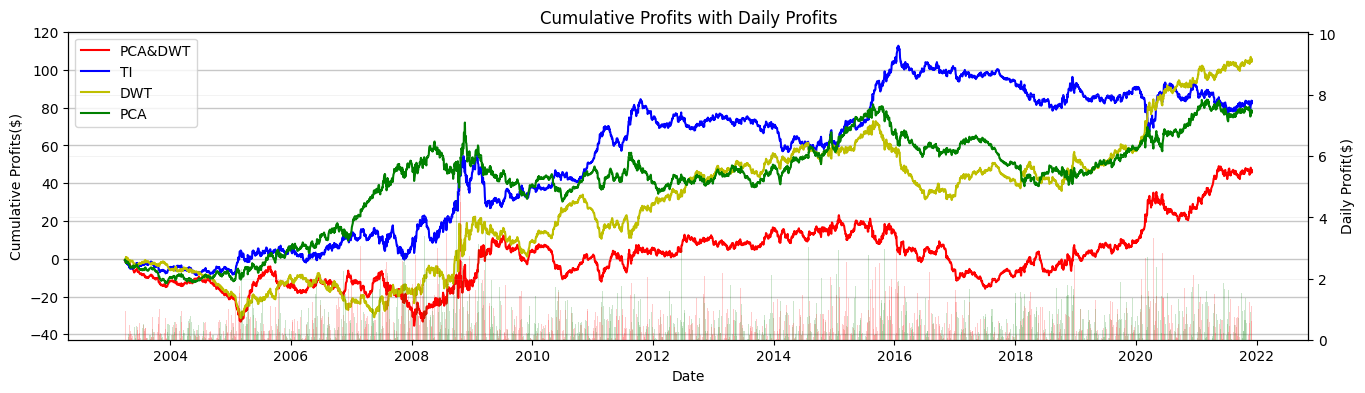

In [ ]:
# from matplotlib import pyplot as plt
Test_returns_PCADWT_XOM = np.loadtxt("results/Test_returns_PCA&DWT_XOM.txt")
Test_returns_DWT_XOM = np.loadtxt("results/Test_returns_DWT_XOM.txt")
Test_returns_PCA_XOM = np.loadtxt("results/Test_returns_PCA_XOM.txt")
Test_returns_TI_XOM = np.loadtxt("results/Test_returns_TI_XOM.txt")

dates1 = df2['Date'].values[-4702:]

fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot the price series on the primary axis
plt.plot(dates1, np.cumsum(Test_returns_PCADWT_XOM), label='PCA&DWT', c='r')
plt.plot(dates1, np.cumsum(Test_returns_TI_XOM), label='TI', c='b')
plt.plot(dates1, np.cumsum(Test_returns_DWT_XOM), label='DWT', c='y')
plt.plot(dates1, np.cumsum(Test_returns_PCA_XOM), label='PCA', c='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Profits($)')
ax1.tick_params(axis='y')
# Set the grid and legend
ax1.grid(axis='y', alpha=0.7,linewidth='1')
ax1.legend(loc='upper left')

# Use a secondary y-axis for the returns bar chart
ax2 = ax1.twinx()
ax2.bar(dates1, np.abs(Test_returns_PCADWT_XOM), color=np.where(Test_returns_PCADWT_XOM < 0, 'red', 'green'), alpha=0.2, width=2.0)
ax2.set_ylabel('Daily Profit($)')
ax2.tick_params(axis='y')
ax2.grid(axis='y',alpha=0.2,linewidth='0.5')

plt.title('Cumulative Profits with Daily Profits')
plt.show()

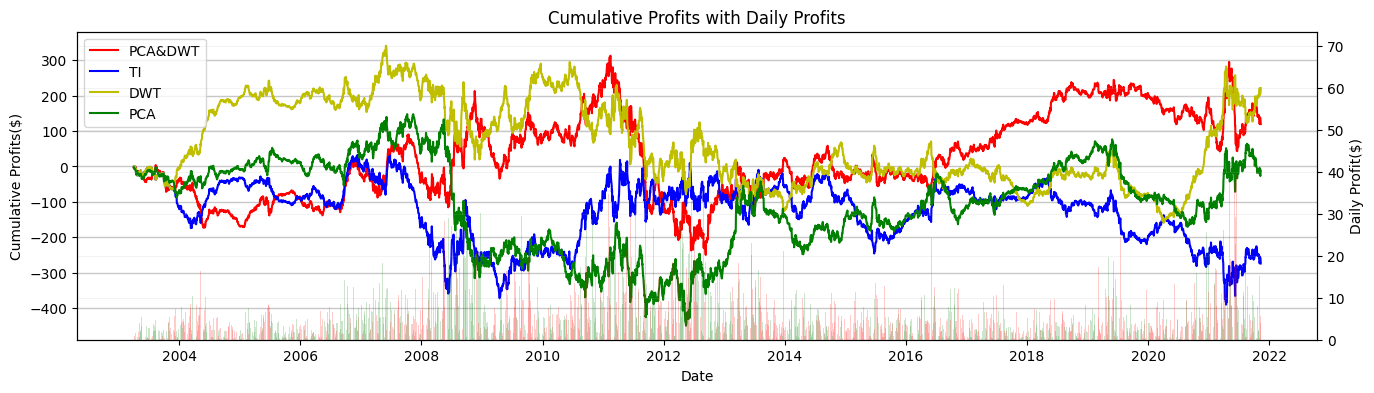

In [ ]:
from matplotlib import pyplot as plt
Test_returns_PCADWT_ZCF = np.loadtxt("results/Test_returns_PCA&DWT_ZCF.txt")
Test_returns_DWT_ZCF = np.loadtxt("results/Test_returns_DWT_ZCF.txt")
Test_returns_PCA_ZCF = np.loadtxt("results/Test_returns_PCA_ZCF.txt")
Test_returns_TI_ZCF = np.loadtxt("results/Test_returns_TI_ZCF.txt")

dates1 = df3['Date'].values[-4686:]

fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot the price series on the primary axis
plt.plot(dates1, np.cumsum(Test_returns_PCADWT_ZCF), label='PCA&DWT', c='r')
plt.plot(dates1, np.cumsum(Test_returns_TI_ZCF), label='TI', c='b')
plt.plot(dates1, np.cumsum(Test_returns_DWT_ZCF), label='DWT', c='y')
plt.plot(dates1, np.cumsum(Test_returns_PCA_ZCF), label='PCA', c='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Profits($)')
ax1.tick_params(axis='y')
# Set the grid and legend
ax1.grid(axis='y', alpha=0.7,linewidth='1')
ax1.legend(loc='upper left')

# Use a secondary y-axis for the returns bar chart
ax2 = ax1.twinx()
ax2.bar(dates1, np.abs(Test_returns_PCADWT_ZCF), color=np.where(Test_returns_PCADWT_ZCF < 0, 'red', 'green'), alpha=0.2, width=2.0)
ax2.set_ylabel('Daily Profit($)')
ax2.tick_params(axis='y')
ax2.grid(axis='y',alpha=0.2,linewidth='0.5')

plt.title('Cumulative Profits with Daily Profits')
plt.show()

## Dry Run (Do not run)

In [ ]:
# Metrics Used to Measure the Performance of Different Methods
# xinyi
def NP(returns: torch.Tensor) -> float:
    # Cumulative return is the sum of individual returns over the trading period
    # returns = returns.detach().cpu().numpy()
    cumulative_return = np.cumsum(returns)
    return cumulative_return

# # irvin - ORIGINAL VERSION
# def ASR(returns: torch.Tensor) -> float:
#   return np.sqrt(252)*(torch.mean(returns)-0.01)/(torch.std(returns))

# irvin - NOT SURE WHAT TO DO WITH FIRST FEW ASR VALUES
def ASR(returns: torch.Tensor) -> float: # calculated over entire set of returns
    err = 1e-5
    # returns = returns.detach().cpu().numpy()
    asr_vals = []
    for i in range(2,len(returns)+1): # ignore first one since std = 0
      return_horizon = returns[:i] # grab all past returns
      asr = np.sqrt(252)*(np.mean(return_horizon)-0.01)/(np.std(return_horizon)+err) # compute ASR value based on past returns
      asr_vals.append(asr) # add to history of ASR values
    return asr_vals

# irvin
#def ASR(returns: torch.Tensor, T: int) -> float: # calculated over previous T returns
#    err = 1e-5
#    returns = returns.detach().cpu().numpy()
#    asr_vals = []
#    for i in range(T): # first T returns
#      return_horizon = returns[:i]
#      asr = np.sqrt(252)*(np.mean(return_horizon)-0.01)/(np.std(return_horizon)+err)
#      asr_vals.append(asr)
#    for i in range(T,len(returns)+1): # rest of returns
#      return_horizon = returns[i-T:i]
#      asr = np.sqrt(252)*(np.mean(return_horizon)-0.01)/(np.std(return_horizon)+err)
#      asr_vals.append(asr)
#    return asr_vals

# sunan
# N_train = 500
# N_test = 500
def APY(P_T):
    MP_0 = create_TI(df)[2].loc[500] # The Market Close Price of the asset at the beginning of Trading
    T=len(P_T)
    return ((P_T[-1]+MP_0)/MP_0)**(252/T)-1

#deep
def MDD(P_T):
    """
    Maximum Drawdown (MDD) calculation.
    returns: List or array of returns
    """
    window = 252

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    P_T = returns_series = pd.Series(P_T)
    Roll_Max = P_T.rolling(window, min_periods=1).max()
    Daily_Drawdown = P_T/Roll_Max

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Daily_Drawdown = 1-Daily_Drawdown.rolling(window, min_periods=1).min()

    return sum(Max_Daily_Drawdown)/len(Max_Daily_Drawdown)

In [ ]:
P_T_NYSE = NP(Test_returns_NYSE)
asr = ASR(Test_returns_NYSE)
apy = APY(P_T_NYSE)
mdd = MDD(P_T_NYSE)
cr = apy/mdd
print("NP",P_T_NYSE[-1])
print('APY',apy)
print("ASR",asr[-1])
print('MDD',mdd)
print('CR',cr)

NP 1436.8359
APY 0.01331332840329913
ASR 0.04932224955762421
MDD 8.201355380733155
CR 0.0016233083173758278


In [ ]:
# # train the model


# lr=0.1
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# X = X.float().to(device)
# rt = rt.float().to(device)
# model = RRLModel_1(X.shape[-1]).float().to(device)

# # optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# model=RRLModel_1(X.shape[-1]).to(device)
# # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# torch.autograd.set_detect_anomaly(True)

# T=8
# offset=1
# delta=0.01
# epochs=50

# # train_1(X: torch.Tensor, rt: torch.Tensor, delta: float, epochs: int = 100, lr: float = 0.1,T:int = 5):
# train_1(X, rt, delta, model, epochs, lr, T)

In [ ]:
# index=0
# T=5
# offset=1
# delta=0.01

# xt=X[index:index+offset+T]
# rt1=rt[index+offset:index+offset+T]

# x0=torch.cat([X[0],torch.tensor([1])],0).float()
# prevFt=model(x0)

# print(model.neuron.weight)
# Ft1 = torch.zeros(T+1).to(X.device)
# # Xinyi
# Ft1 = predict_Ft(xt, model, prevFt)
# # Xinyi
# # Ft1 = predict_Ft_1(xt, model, prevFt)
# returns, reward = reward_function(rt1, delta, Ft=Ft1)
# print(returns,"\n",reward)
# (-1 * reward).backward(retain_graph=True)
# optimizer.step()
# print(model.neuron.weight)

In [ ]:
# train(X[:501],rt[:501],delta=0.1,epochs=10,lr=0.01,T=5)
# model.neuron.weight

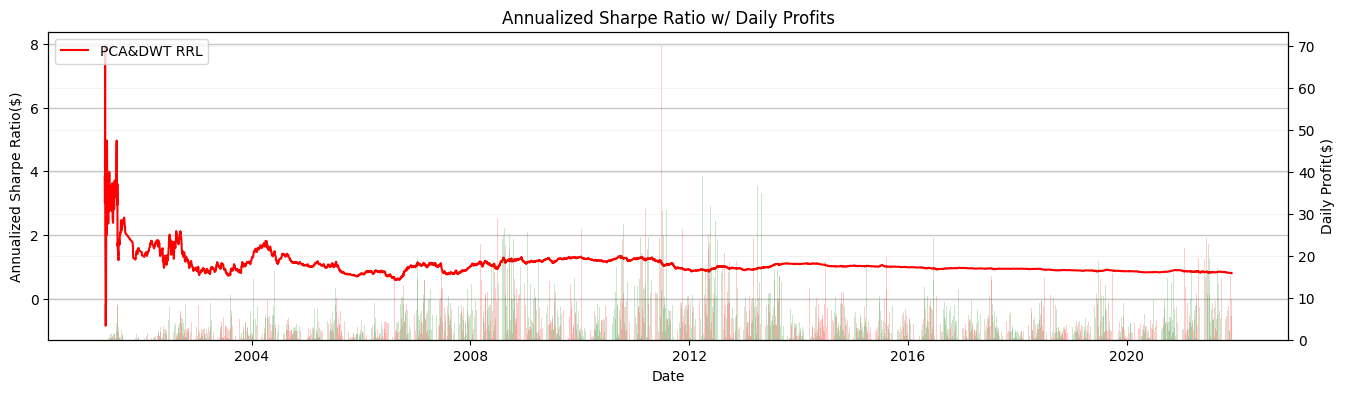

In [ ]:
total_returns_np = total_returns.detach().cpu().numpy()
# total_Ft_np = total_Ft.detach().cpu().numpy()
###########!!!!!!!!Should be on Close Price!!!!!
dates1 = df['Date'][64:].values

fig, ax1 = plt.subplots(figsize=(16, 4))

# Plot the price series on the primary axis
plt.plot(dates1[1:], asr, label='PCA&DWT RRL', c='r')
ax1.set_xlabel('Date')
ax1.set_ylabel('Annualized Sharpe Ratio($)')
ax1.tick_params(axis='y')
# Set the grid and legend
ax1.grid(axis='y', alpha=0.7,linewidth='1')
ax1.legend(loc='upper left')

# Use a secondary y-axis for the returns bar chart
ax2 = ax1.twinx()
ax2.bar(dates1, np.abs(total_returns_np), color=np.where(total_returns_np < 0, 'red', 'green'), alpha=0.2, width=2.0)
ax2.set_ylabel('Daily Profit($)')
ax2.tick_params(axis='y')
ax2.grid(axis='y',alpha=0.2,linewidth='0.5')

plt.title('Annualized Sharpe Ratio w/ Daily Profits')
plt.show()

notice they are different

## Notes

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [15, 1]], which is output 0 of AsStridedBackward0, is at version 5; expected version 4 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

Cannot figure this out.

In [ ]:
# class RRLModel(nn.Module):
#     def __init__(self, m):
#         super().__init__()
#         self.m = m
#         self.neuron = nn.Linear(m+1, 1, bias = True)
#         nn.init.uniform_(self.neuron.weight, -.2, .2)
#         nn.init.constant_(self.neuron.bias, 0)

#     def forward(self, features):
#         return torch.tanh(self.neuron(features))#use tanh or sign? We need Ft={-1,1}

# #len(rt)=5 for training, 500 for testing
# #len(Ft)=5+1 for Training, 500+1 for Testing
# def reward_function(rt: torch.Tensor, delta: float, Ft: torch.Tensor):
#     #calculate return for each day and return sharpe ratio for the batch
#     returns = Ft[:-1]*rt -delta*(torch.abs(Ft[1:]-Ft[:-1]))
#     sharpe = sharpe_ratio(returns)
#     return returns, sharpe

# def sharpe_ratio(returns: torch.Tensor,bias:int=1e-6):
#     #using biased estimator to ensure std!=0
#     mean = torch.mean(returns, dim=-1)
#     squared_mean = torch.mean(returns ** 2, dim=-1)
#     std=torch.sqrt(squared_mean-mean**2)+bias
#     return mean/std

# # this function might be wrong --Xinyi
# def predict_Ft(X: torch.Tensor,  model: RRLModel, prev: torch.Tensor):
#     #make t predictions
#     #ith prediction depends on i-1, using prev to intialize first signal
#     Ft1[0]=prev
#     for i in range(T):
#         x_i=torch.cat([X[i],Ft1[i].unsqueeze(0)],0).float()
#         Ft1[i+1] = model(x_i)
#     return Ft1

# def gradient_accent(X: torch.Tensor, rt: torch.Tensor, model: RRLModel, epochs: int, lr: float, T:int, delta:float):

#     batches=int((X.shape[0]-1)/T)
#     for i in range(epochs):
#         #need some random signal to calculate Ft at t=0
#         x0=torch.cat([X[0],torch.tensor([1])],0).float()
#         prevFt=model(x0)
#         for j in range(batches):
#             index=j*T
#             optimizer.zero_grad()#reset gradient
#             # This line of detach Ft1 might be wrong
#             Ft1 = predict_Ft(X[index+offset:index+offset+T], model, prevFt)
#             returns, reward = reward_function(rt[index+offset:index+offset+T], delta, Ft=Ft1)
#             (-1 * reward).backward(retain_graph=True)
#             optimizer.step()

#             prevFt=Ft1[-1].unsqueeze(0)

# #len(X)=501,len(rt)=501, First rt unused
# def train(X: torch.Tensor, rt: torch.Tensor, delta: float, epochs: int = 100, lr: float = 0.1,T:int = 5):
#     #model = RRLModel(X.shape[-1])
#     gradient_accent(X, rt, model, epochs, lr,T,delta)

# def test(X: torch.Tensor, rt: torch.Tensor, delta: float):
#     test_Ft = predict_Ft(X,rt, model,torch.tensor([1]))
#     test_returns, test_rewards = reward_function(rt[1:], delta, test_Ft)
#     return test_rewards,test_returns,test_Ft

# #     percentage_returns = (torch.exp(torch.log(1 + returns_ahead).cumsum(dim=-1))

In [ ]:
# class RRLModel(nn.Module):
#     def __init__(self, m):
#         super().__init__()
#         self.m = m
#         self.neuron = nn.Linear(m+1, 1, bias = True)
#         nn.init.uniform_(self.neuron.weight, -.2, .2)
#         nn.init.constant_(self.neuron.bias, 0)

#     def forward(self, features):
#         return torch.tanh(self.neuron(features))#use tanh or sign? We need Ft={-1,1}

# def sharpe_ratio_1(returns: torch.Tensor,bias:int=1e-6):
#     #using biased estimator to ensure std!=0
#     mean = torch.mean(returns, dim=-1)
#     squared_mean = torch.mean(returns ** 2, dim=-1)
#     std=torch.sqrt(squared_mean-mean**2)+bias
#     return mean/std

# #len(rt)=5 for training, 500 for testing
# #len(Ft)=5+1 for Training, 500+1 for Testing
# def reward_function_1(rt: torch.Tensor, delta: float, Ft: torch.Tensor):
#     #calculate return for each day and return sharpe ratio for the batch
#     returns = Ft[:-1]*rt -delta*(torch.abs(Ft[1:]-Ft[:-1]))
#     sharpe = sharpe_ratio_1(returns)
#     return returns, sharpe


# def predict_Ft_1(X: torch.Tensor,  model: RRLModel, prev: torch.Tensor):
#     T = X.shape[0]
#     Ft1_values = [prev.unsqueeze(0)]

#     for i in range(T):
#         # Make sure both tensors have the same number of dimensions before concatenation
#         x_i = torch.cat([X[i].unsqueeze(0), Ft1_values[-1].detach().flatten().unsqueeze(0)], 1)
#         Ft1_values.append(model(x_i))
#     Ft1 = torch.stack(Ft1_values).squeeze()
#     return Ft1

# def gradient_accent_1(X: torch.Tensor, rt: torch.Tensor, model: RRLModel, epochs: int, lr: float, T:int, delta:float):
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     batches=int((X.shape[0]-1)/T)
#     for i in range(epochs):
#       print(i)
#       #need some random signal to calculate Ft at t=0
#       x0=torch.cat([X[0],torch.tensor([1])],0).float()
#       prevFt=model(x0)
#       for j in range(batches):
#         # print(j)
#         index=j*T
#         optimizer.zero_grad()#reset gradient
#         Ft1 = predict_Ft_1(X[index+offset:index+offset+T], model, prevFt)
#         # print(Ft1._version)
#         returns, reward = reward_function_1(rt[index+offset:index+offset+T], delta, Ft=Ft1.clone())
#         reward = reward.clone()
#         (-1 * reward).backward(retain_graph=True)
#         optimizer.step()
#         prevFt=Ft1[-1].clone().unsqueeze(0)

# #len(X)=501,len(rt)=501, First rt unused
# def train_1(X: torch.Tensor, rt: torch.Tensor, delta: float, model: RRLModel, epochs: int = 100, lr: float = 0.1,T:int = 5):
#     gradient_accent_1(X, rt, model, epochs, lr,T,delta)


# def test_1(X: torch.Tensor, rt: torch.Tensor, model: RRLModel, delta: float):
#     test_Ft = predict_Ft_1(X, model, torch.tensor([1]))
#     test_returns, test_rewards = reward_function_1(rt[1:], delta, test_Ft)
#     return test_rewards, test_returns, test_Ft

Probably beacuse Ft1[0] being set to prev. Need to find a way around it.

## new (do not run)


In [ ]:
def create_TI(df):
    df_ti = pd.DataFrame()

    # Notes for the indicators: https://docs.google.com/document/d/1YCS1o-z_5Q-uq3_UDVLstW-R1Gi6xUXumaJxqzyELpY/edit --Lily

    #Momentum indicators
    #real = MOM(close, timeperiod=10)
    #macd, macdsignal, macdhist = MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    #real = MFI(high, low, close, volume, timeperiod=14)
    #real = RSI(close, timeperiod=14)

    df_ti['mom'] = pd.DataFrame(talib.MOM(df['Close'])) # Momentum (MOM)
    df_ti['macd'], df_ti['macdsignal'], df_ti['macdhist'] = talib.MACD(df['Close'])# Moving Average Convergence Divergence (MACD)
    df_ti['mfi'] = talib.MFI(df['High'],df['Low'],df['Close'],df['Volume'])# Money Flow Index (MFI)
    df_ti['rsi'] = talib.RSI(df['Close'])# Relative Strength Index (RSI)

    #Volatility Indicators
    #real = ATR(high, low, close, timeperiod=14)
    #real = NATR(high, low, close, timeperiod=14)

    df_ti['atr'] = talib.ATR(df['High'], df['Low'], df['Close'])# Average True Range (ATR)
    df_ti['natr'] = talib.NATR(df['High'], df['Low'], df['Close'])# Normalized Average True Range (NATR)

    #Cycle Indicators
    #real = HT_DCPHASE(close)
    #sine, leadsine = HT_SINE(close)
    #integer = HT_TRENDMODE(close)

    df_ti['htdcp'] = talib.HT_DCPHASE(df['Close'])# Hilbert Transform Dominant Cycle Phase (HTDCP)
    df_ti['hts'], df_ti['hts_lead'] = talib.HT_SINE(df['Close']) # Hilbert Transform Sinewave (HTS)
    df_ti['httmm'] = talib.HT_TRENDMODE(df['Close']) # Hilbert Transform Trend Market Mode (HTTMM)

    #Volume Indicators
    #real = ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    #real = OBV(close, volume)

    df_ti['co'] = talib.ADOSC(df['High'], df['Low'], df['Close'], df['Volume'])# Chaikin Oscillator (CO)
    df_ti['obv'] = talib.OBV(df['Close'], df['Volume'])# On Balance Volume (OBV)

    #df_ti['returns'] = (df['Close']-df['Open'])/df['Open']
    df_ti['returns'] = (df['Close']-df['Open'])

    df_ti.dropna(inplace=True)
    returns = df_ti['returns']
    df_ti.drop('returns', axis = 1, inplace = True)

    return df_ti, returns, df['Close']

def normalize(data):
    data=(data-data.mean())/data.std()
    return data

def apply_PCA(data,ratio=0.95):
    pca = PCA(n_components=ratio)
    pca.fit(data)
    data_pca=pca.transform(data)
    data_pca=pd.DataFrame(data_pca,columns=["PCA_"+str(i) for i in range(data_pca.shape[1])])
    return data_pca


def apply_DWT(signal,level=4,threshold=2):
    #DWT with level=4
    coeffs= pywt.wavedec(signal, 'haar', level)
    #soft thresholding applied to all detail coefficients
    for i in range(1,level):
        coeffs[i]=pywt.threshold(coeffs[i],threshold*np.std(coeffs[i]),'soft',0)
    #inverse DWT
    reconstructed_signal=pywt.waverec(coeffs,'haar')
    return reconstructed_signal

def preprocessing_pipeline(df_ti, mType = 'pcadwt', level=4,threshold=2):
    df_ti_norm=normalize(df_ti)
    df_pca=apply_PCA(df_ti_norm)
    df_dwt=df_ti.apply(apply_DWT,args=[level,threshold])
    df_pca_dwt=df_pca.apply(apply_DWT,args=[level,threshold])

    if mType == 'ti' or mType == 'TI':
      return df_ti_norm
    elif mType == 'pca' or mType == 'PCA':
      return df_pca
    elif mType == 'dwt' or mType == 'DWT':
      return df_dwt
    elif mType =='pca&dwt' or mType == 'PCA&DWT':
      return df_pca_dwt

### Define the Model Structure

In [ ]:
# build of F_t (on activation function)
class RRLModel(nn.Module):
  def __init__(self, m, T):
    super().__init__()
    self.m = m
    self.neuron = nn.Linear(m+1, 1, bias = True)
    nn.init.uniform_(self.neuron.weight, -.2, .2)
    nn.init.constant_(self.neuron.bias, 0)

  def forward(self, features):
    return torch.tanh(self.neuron(features))#use tanh or sign? We need Ft={-1,1}


class RRLTrainer:
    def __init__(self, model: RRLModel, lr: float, delta: float, T: int, lamb: float):
        self.model = model
        self.lr = lr
        self.delta = delta
        self.T = T
        self.lamb=lamb
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lamb)#add Regularisation -- weight_decay parameter
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #self.return_list = []
        #self.action_list = []

    @staticmethod
    def sharpe_ratio(returns: torch.Tensor, bias: int = 1e-6):
        mean = torch.mean(returns, dim=-1)
        squared_mean = torch.mean(returns ** 2, dim=-1)
        #std = torch.sqrt(squared_mean - mean ** 2) + bias
        std = torch.std(returns, dim=-1) + bias
        return mean / std

    def reward_function(self, rt: torch.Tensor, Ft: torch.Tensor):
        returns = Ft[:-1] * rt - self.delta * (torch.abs(Ft[1:] - Ft[:-1]))
        sharpe = self.sharpe_ratio(returns)
        return returns, sharpe

    def predict_Ft(self, X: torch.Tensor, prev: torch.Tensor):
        Ft1_values = torch.zeros(X.shape[0]+1).to(self.device)
        Ft1_values[0]=prev
        for i in range(len(X)-1):
            x_i=torch.cat([X[i],Ft1_values[i].detach().unsqueeze(0)],0).float()
            Ft1_values[i+1] = self.model(x_i)
        return torch.sign(Ft1_values)

    def gradient_ascent(self, X: torch.Tensor, rt: torch.Tensor):
        batches = int((X.shape[0] - 1) / self.T)
        print ("Epochs: ",end=" ")
        for epoch in range(self.epochs):
            print(f'{epoch+1} ',end=" " )

            prevFt= torch.tensor([1]).float()# Going Long on Day 0, initializing prevFt to 1
            for batch in range(batches):
                index = batch * self.T
                self.optimizer.zero_grad()
                Ft1 = self.predict_Ft(X[index :index + self.T], prevFt)
                returns, reward = self.reward_function(rt[index :index + self.T], Ft1.clone())
                reward = reward.clone()
                (-1 * reward).backward(retain_graph=True)
                self.optimizer.step()
                prevFt = Ft1[-1].clone().unsqueeze(0)
        print()

    def train(self, X: torch.Tensor, rt: torch.Tensor, epochs: int = 100):
        self.epochs = epochs
        self.gradient_ascent(X, rt)

    def test(self, X_test: torch.Tensor, rt_test: torch.Tensor):
        prevFt= torch.tensor([1]).float()
        #test_Ft = self.predict_test_Ft(X_test)
        test_Ft=self.predict_Ft(X_test, prevFt)
        test_returns, test_rewards = self.reward_function(rt_test, test_Ft)
        return test_rewards, test_returns, test_Ft[1:] #test_Ft contains prev_Ft,excluding that

### Auxilliary Functions

In [ ]:
import json
def read_file(path):
  df = pd.read_csv(path)
  df.drop(columns = ['Name'], inplace = True)
  df['Date'] = pd.to_datetime(df['Date'])
  return df

results_path="/content/gdrive/MyDrive/Notebooks/results"

def save_results(test_returns,test_rewards,test_ft,df_name,model_name):
  data={"test_returns":test_returns,"test_rewards":test_rewards,"test_ft":test_ft}
  json_object = json.dumps(data, indent=4)
  with open(f'{results_path}/{df_name}_{model_name}.json', "w+") as outfile:
    outfile.write(json_object)

def read_results(df_name,model_name):
  with open(f'{results_path}/{df_name}_{model_name}.json', 'r') as openfile:
    json_object = json.load(openfile)
  return json_object


### Dry Run

In [ ]:
# NYSE
df1 = pd.read_csv("data/NYSE_20yr_OHLC.csv")
df1.drop(columns = ['Name'], inplace = True)
df1['Date'] = pd.to_datetime(df1['Date'])

# NYSE
df_ti, returns, df_close = create_TI(df1)
df_pca_dwt = preprocessing_pipeline(df_ti, 'PCA&DWT')

In [ ]:
lr=0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T=5
delta=1
epochs=10
lamb=0.01  #regularization parameter
train_size=500
test_size=500

In [ ]:
X = torch.tensor(df_pca_dwt.values) #, requires_grad = True)
rt = torch.tensor(returns.values) #, requires_grad = True)

X_train = X[:500].float().to(device)
rt_train = rt[:500].float().to(device)
print(X_train.shape,rt_train.shape)

X_test = X[500:1000].float().to(device)
rt_test = rt[500:1000].float().to(device)
print(X_train.shape,rt_train.shape)

torch.Size([500, 9]) torch.Size([500])
torch.Size([500, 9]) torch.Size([500])


In [ ]:
model = RRLModel(X_train.shape[-1],T).float().to(device)
torch.autograd.set_detect_anomaly(True)
trainer = RRLTrainer(model, lr, delta, T, lamb)
trainer.train(X_train, rt_train, 10)

Epochs:  1  2  3  4  5  6  7  8  9  10  


In [ ]:
test_rewards,test_returns,test_ft=trainer.test(X_test,rt_test)

In [ ]:
torch.sum(test_returns)

tensor(342.5493, grad_fn=<SumBackward0>)

### Rolling Training and Testing

In [ ]:
def rolling_training_testing(df,returns,df_name:str,model_name:str,delta,N_train=500,N_test=500,T=5,lr=0.1,epochs=10,lamb=0.01):

  X = torch.tensor(df.values) #, requires_grad = True)
  rt = torch.tensor(returns.values)
  model = RRLModel(X.shape[-1],T).float().to(device)
  torch.autograd.set_detect_anomaly(True)
  trainer = RRLTrainer(model, lr, delta, T, lamb)

  rewards_list=[]
  returns_list=[]
  ft_list=[]

  for i in range(10):
    start=i*N_train
    print(f"Training on Batch {i+1}")
    X_train = X[start:start+N_train].float().to(device)
    rt_train = rt[start:start+N_train].float().to(device)
    trainer.train(X_train, rt_train, epochs)

    print(f"Testing on Batch {i+2}")
    X_test = X[start+N_train:start+N_train+N_test].float().to(device)
    rt_test = rt[start+N_train:start+N_train+N_test].float().to(device)
    test_rewards,test_returns,test_ft=trainer.test(X_test,rt_test)

    rewards_list.append(test_rewards.detach().cpu().numpy().tolist())
    returns_list.extend(test_returns.detach().cpu().numpy().tolist())
    ft_list.extend(test_ft.detach().cpu().numpy().tolist())
    print()

  path = '/content/gdrive/MyDrive/Notebooks/model/{}_{}_RRL_1204.pth'.format(df_name,model_name)
  torch.save(model.state_dict(), path)
  print('Successfully saved {} RRL model for {}'.format(model_name,df_name))

  return rewards_list,returns_list,ft_list




### Measurement Matrix

In [ ]:
import math
# Metrics Used to Measure the Performance of Different Methods
def cumulative_returns(returns):
  return np.cumsum(returns)

def NP(returns):
  return np.sum(returns)

def ASR(returns):
  return np.sqrt(252)*(np.mean(returns)-0.01)/(np.std(returns))

#MP_0=df_close[500]
def APY(returns,P_T,MP_0): #wrong, neeeds to be corrected
  val=(P_T+MP_0)/MP_0
  sign=np.sign(val) # for situations when val is less than zero, Can't find root of a negative number
  apy= sign *math.pow(np.abs(val) , (252.0/len(returns)) )-1
  return apy

def MDD(returns):
  time_series=np.cumsum(returns)
  drawdown=( np.maximum.accumulate(time_series) - time_series ) / np.maximum.accumulate(time_series)
  return np.max(drawdown)

def CR(apy,mdd):
    if mdd == 0:
        return np.inf
    return apy/mdd

def get_metrics(returns,MP_0):
  Metrics=["NP($)","APY","ASR","MD","CR"]
  np=NP(returns)
  apy=APY(returns,np,MP_0)
  asr=ASR(returns)
  mdd=MDD(returns)
  cr=CR(apy,mdd)
  df=pd.DataFrame({"Metrics":Metrics,"Values":[np,apy,asr,mdd,cr]})

  return df

def add_columns(df,df_name,model_name):
  df.insert(0,"Model",model_name)
  df.insert(0,"Dataset",df_name)
  return df



### Results

In [ ]:
# NYSE
df_name="NYSE"
model_name="PCA&DWT"
delta=1
lamb=0.01
epochs=10
torch.manual_seed(7)

df = read_file(f"data/{df_name}_20yr_OHLC.csv")
df_ti, returns, df_close = create_TI(df)
df_transformed = preprocessing_pipeline(df_ti,model_name)

test_rewards,test_returns,test_ft=rolling_training_testing(df_transformed,returns,df_name,model_name,delta=delta,epochs=epochs,lamb=lamb)
save_results(test_returns,test_rewards,test_ft,df_name,model_name)
get_metrics(test_returns,df_close[500]).style.set_caption("NYSE-PCA&DWT-Seed=7")

Training on Batch 1
Epochs:  1  2  3  4  5  6  7  8  9  10  
Testing on Batch 2

Training on Batch 2
Epochs:  1  2  3  4  5  6  7  8  9  10  
Testing on Batch 3

Training on Batch 3
Epochs:  1  2  3  4  5  6  7  8  9  10  
Testing on Batch 4

Training on Batch 4
Epochs:  1  2  3  4  5  6  7  8  9  10  
Testing on Batch 5

Training on Batch 5
Epochs:  1  2  3  4  5  6  7  8  9  10  
Testing on Batch 6

Training on Batch 6
Epochs:  1  2  3  4  5  6  7  8  9  10  
Testing on Batch 7

Training on Batch 7
Epochs:  1  2  3  4  5  6  7  8  9  10  
Testing on Batch 8

Training on Batch 8
Epochs:  1  2  3  4  5  6  7  8  9  10  
Testing on Batch 9

Training on Batch 9
Epochs:  1  2  3  4  5  6  7  8  9  10  
Testing on Batch 10

Training on Batch 10
Epochs:  1  2  3  4  5  6  7  8  9  10  
Testing on Batch 11

Successfully saved PCA&DWT RRL model for NYSE


,Metrics,Values
0,NP($),3289.737305
1,APY,0.026843
2,ASR,0.114990
3,MD,1.407814
4,CR,0.019067


In [ ]:
r1=get_metrics(test_returns,df_close[500]).style.set_caption("NYSE-PCA&DWT-Seed=43")
r1

,Metrics,Values
0,NP($),-4936.654297
1,APY,-0.157691
2,ASR,-0.176629
3,MD,2.703165
4,CR,-0.058336


In [ ]:
results_df=pd.DataFrame(columns=["Dataset","Model","Metrics","Values"])
t=get_metrics(test_returns,df_close[500])
t=add_columns(t,"NYSE","PCA&DWT")
pd.concat([results_df,t])

,Dataset,Model,Metrics,Values
0,NYSE,PCA&DWT,NP($),-472.135742
1,NYSE,PCA&DWT,APY,-0.005144
2,NYSE,PCA&DWT,ASR,-0.018391
3,NYSE,PCA&DWT,MD,17.734585
4,NYSE,PCA&DWT,CR,-0.000290


### Benchmarking

In [ ]:
epochs=10
lamb=0.01
torch.manual_seed(43)

df_names=["NYSE","Exxon","Corn"]
model_names=["PCA&DWT"]
deltas=[1,0.01,0.001]

metrics_df=pd.DataFrame(columns=["Dataset","Model","Metrics","Values"])

for i,df_name in enumerate(df_names):
  df = read_file(f"data/{df_name}_20yr_OHLC.csv")
  df_ti, returns, df_close = create_TI(df)

  for model_name in model_names:
    df_transformed = preprocessing_pipeline(df_ti,model_name)
    test_rewards,test_returns,test_ft=rolling_training_testing(df_transformed,returns,df_name,model_name,delta=deltas[i],epochs=epochs,lamb=lamb)
    save_results(test_returns,test_rewards,test_ft,df_name,model_name)
    metrics=get_metrics(test_returns,df_close[500])
    metrics=add_columns(metrics,df_name,model_name)
    metrics_df=pd.concat([metrics_df,metrics])

Training on Batch 1
Epochs:  1  2  3  4  5  

KeyboardInterrupt: ignored

In [ ]:
#results_df
metrics_df.Values=metrics_df.Values.round(2)
pd.pivot_table(metrics_df,index=["Dataset","Metrics"],columns="Model",values="Values", sort=False)

In [ ]:
metrics_df=pd.DataFrame(columns=["Dataset","Model","T", "eS","Metrics","Values"])

def train_and_test_model(model, X_train, rt_train, X_test, rt_test, lr, delta, T, epochs, lamb, early_stop):
  trainer = RRLTrainer(model, lr, delta, T, lamb, early_stop)
  trainer.train(X_train, rt_train, epochs)
  model.eval()
  # Test the model on the remaining samples
  # tester = RRLTrainer(model, lr, delta, T)
  test_rewards, test_returns, test_Ft = trainer.test(X_test, rt_test)
  return  test_rewards, test_returns, test_Ft

def training_pipeline(df_name, modelName, delta, T_, epochs, lamb=1e-5, N=500, lr=0.1, T=5, patience=2, early_stop=False):
    print('start on {}'.format(df_name))
    df = pd.read_csv(f"data/{df_name}_20yr_OHLC.csv")
    df.drop(columns = ['Name'], inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    # df = read_file(f"data/{df_name}_20yr_OHLC.csv")
    df_ti, returns, df_close = create_TI(df)
    # print(df_ti)
    df_transformed = preprocessing_pipeline(df_ti, modelName)
    X = torch.tensor(df_transformed.values).float()  # Assuming df is your DataFrame
    rt = torch.tensor(returns.values) #, requires_grad = True)
    model = RRLModel(X[:N_train].shape[-1],T).float().to(device)
    torch.autograd.set_detect_anomaly(True)
    Test_rewards=[]
    Test_returns=[]
    Test_Ft=[]
    for start_index in range(0, len(X)-N_train, N_train):
        # Define the training and testing slices
        end_index = start_index + N_train
        X_train = X[start_index:end_index].float().to(device)
        rt_train = rt[start_index:end_index].float().to(device)
        # Ensuring we don't go beyond the length of X for testing
        test_end_index = end_index + N_train if end_index + N_train < len(X) else len(X)
        X_test = X[end_index:test_end_index].float().to(device)
        rt_test = rt[end_index:test_end_index].float().to(device)

        # Train and test the model
        print(f'Training on {start_index} to {end_index}, testing on {end_index} to {test_end_index}.')
        test_rewards, test_returns, test_Ft = train_and_test_model(model, X_train,rt_train, X_test, rt_test, lr, delta, T_ , epochs, lamb, early_stop)
        Test_rewards.append(test_rewards)
        Test_returns.append(test_returns)
        Test_Ft.append(test_Ft)

    # After training, save the model if you need to save the model
    path = '/content/gdrive/MyDrive/Notebooks/model/{}_T={}_eS={}_RRL_1212.pth'.format(modelName, T_, early_stop)
    torch.save(model.state_dict(), path)
    print('PCA&DWT saved {}_{} RRL model.'.format(modelName, df_name))
    Test_rewards = torch.stack([t.detach().cpu() for t in Test_rewards]).numpy()
    Test_returns = torch.cat([t.detach().cpu() for t in Test_returns], dim=0).numpy()
    Test_Ft = torch.cat([t.detach().cpu() for t in Test_Ft], dim=0).numpy()
    try:
        metrics=get_metrics(Test_returns,df_close[500])
        return Test_rewards, Test_returns, Test_Ft, metrics
    except:
        return Test_rewards, Test_returns, Test_Ft, []
    # Loading
    # X_pd, X_train_pd, X_test_pd = get_input(df_pca_dwt)
    # model_pca_dwt = RRLModel_1(X_train_pd.shape[-1],T)
    # model_pca_dwt.load_state_dict(torch.load("/content/gdrive/MyDrive/Notebooks/model/RRL_model_1111.pth"))
    # return Test_rewards, Test_returns, Test_Ft, metrics